In [1]:
from ipynb.fs.full.library import *
from weight import *
import numpy as np
import copy
from findiff import FinDiff

# copying load method
def load(filename, nload):
    to_load = []
    with open(filename, 'rb') as f:
        for i in range(nload):
            to_load.append(np.load(f))
    return tuple(to_load)

class IntegrationDomain(object):
    def __init__(self, min_corner, max_corner):
        # min_corner - min coordinates in each dimension; sim. max_corner
        self.min_corner = min_corner
        self.max_corner = max_corner
        self.shape = [max_c-min_c+1 for (min_c, max_c) in zip(self.min_corner, self.max_corner)]
        
    def __repr__(self):
        return f"IntegrationDomain({self.min_corner}, {self.max_corner})"
    
class Weight(object):
    def __init__(self, m, q, k, scale=1, dxs=None):
        self.m = m
        self.q = q
        self.k = k
        self.scale = scale
        self.ready = False
        self.weight_obj = None
        if dxs is None:
            self.dxs = [1]*len(self.m)
        else:
            self.dxs = dxs
    
    def make_weight_objs(self):
        self.ready = True
        self.weight_objs = [weight_1d(m, q, k, dx) for (m, q, k, dx) in zip(self.m, self.q, self.k, self.dxs)]
    
    def get_weight_array(self, dims):
        if not self.ready:
            self.make_weight_objs()
        weights_eval = [weight.linspace(dim)[1] for (weight, dim) in zip(self.weight_objs, dims)]
        return self.scale*reduce(lambda x, y: np.tensordot(x, y, axes=0), weights_eval)
        #return self.scale*weight_array(self.m, self.q, self.k, dims)
    
    def increment(self, dim): # return new weight with an extra derivative on the dim-th dimension
        knew = self.k.copy()
        knew[dim] += 1
        return Weight(self.m, self.q, knew, scale=self.scale, dxs=self.dxs)
    
    def __neg__(self):
        return Weight(self.m, self.q, self.k, scale=-self.scale, dxs=self.dxs)
    
    def __mul__(self, number):
        return Weight(self.m, self.q, self.k, scale=self.scale*number, dxs=self.dxs)
        
    __rmul__ = __mul__
    
    def __repr__(self):
        return f"Weight({self.m}, {self.q}, {self.k}, {self.scale}, {self.dxs})"
        
def make_domains(dims, world_size, ndomains, pad=0):
    domains = []
    for i in range(ndomains):
        min_corner = []
        max_corner = []
        for (L, max_lim) in zip(dims, world_size):
            num = np.random.randint(pad, max_lim-(L+pad)+1)
            min_corner.append(num)
            max_corner.append(num+L-1)
        domains.append(IntegrationDomain(min_corner, max_corner))
    return domains

def get_slice(arr, domain):
    arr_slice = arr
    for (slice_dim, min_c, max_c) in zip(range(arr.ndim), domain.min_corner, domain.max_corner):
        idx = [slice(None)]*arr.ndim
        idx[slice_dim] = slice(min_c, max_c+1)
        arr_slice = arr_slice[tuple(idx)]
    return arr_slice

### integrate by parts and specify weight functions ###
def int_by_parts(term, weight, dim=0):
    if dim>=term.ndims:
        yield term, weight
    else:
        failed = False
        for te, we, fail in int_by_parts_dim(term, weight, dim): # try to integrate by parts
            failed = (failed or fail)
            if failed: # can't continue, so go to next dimension
                dim += 1
            yield from int_by_parts(te, we, dim) # repeat process (possibly on next dimension)

# for integration by parts, check terms that look like x', x*x', and x*x*x' (vs all other terms have derivative orders smaller by at least 2)
# this misses out on opportunities to integrate by parts using a different basis, but this seems too difficult to automate; 
# at this point it's probably easier to just write the term out manually.
def int_by_parts_dim(term, weight, dim):
    # find best term to base integration off of
    #best_prim, next_best, third_best = None, None, None
    #best_i, next_i, third_i = None, None, None
    best_prim, next_prim = None, None
    best_i, next_i = None, None
    for (i, prim) in enumerate(term.observable_list):
        if prim.nderivs == term.nderivs:
            if best_prim is None:
                best_i, best_prim = i, prim
                if prim.dimorders[dim]==0: # can't integrate by parts along this dimension
                    yield term, weight, True
                    return 
            else: # multiple candidate terms -> integrating by parts will not help
                yield term, weight, True
                return  
        elif prim.nderivs == term.nderivs-1 and next_prim is None:
            next_i, next_prim = i, prim
        #elif prim.nderivs == term.nderivs-2:
        #    third_i, third_best = i, prim
    # check viability by cases
    newords = best_prim.dimorders.copy()
    newords[dim] -= 1
    new_weight = weight.increment(dim)
    new_prim = IndexedPrimitive(best_prim, newords=newords)
    #print(term, best_prim)
    rest = term.drop(best_prim)
    if next_prim is None: # then all other terms have derivatives up to order n-2, so we are in x' case
        for summand in rest.diff(dim):
            yield new_prim*summand, -weight, False
        yield new_prim*rest, -new_weight, False
        return
    else:
        #print(rest, next_prim)
        rest = rest.drop(next_prim)
        if next_prim.succeeds(best_prim, dim): # check if next_best goes with best
            # check if next best is unique
            for obs in rest.observable_list:
                if obs == next_prim: # can stop here because we limit the number of terms
                    # x' * x * x case
                    #print(rest, next_prim)
                    rest = rest.drop(obs)
                    for summand in rest.diff(dim):
                        yield next_prim*next_prim*next_prim*summand, -1/3*weight, False
                    yield next_prim*next_prim*next_prim*rest, -1/3*new_weight, False
                    return
                elif obs.nderivs == term.nderivs-1: # not unique and doesn't match
                    yield term, weight, True
                    return
            # x' * x case
            for summand in rest.diff(dim):
                yield next_prim*next_prim*summand, -1/2*weight, False
            yield next_prim*next_prim*rest, -1/2*new_weight, False
            return
        else:
            yield term, weight, True
            return

def diff(data, dorders, dxs=None):
    # for spatial directions can use finite differences or spectral differentiation. For time, only the former.
    # in any case, it's probably best to pre-compute the derivatives on the whole domains (at least up to order 2). with integration by parts, there shouldn't be higher derivatives.
    acc = 2 # order of accuracy that we want
    if dxs is None:
        dxs = [1]*len(dorders)
    diff_list = []
    for i, dx, order in zip(range(len(dxs)), dxs, dorders):
        if order>0:
            diff_list.append((i, dx, order))
    diff_operator = FinDiff(*diff_list, acc=acc)
    return diff_operator(data)

# cache the derivatives through order 2? fill in code below for using cache

def encode(obs_name, dorders):
    # e.g. dxx
    return ""

def decode(data_name):
    # return obs_name, dorders
    return "", [0, 0, 0]

def eval_term(ts, weight, data_dict, domain, dxs): #, dim
    # ts: TermSum or LibraryTerm
    # weight
    # data_dict: keys are Observable names, values are data arrays
    # domain: IntegrationDomain corresponding to where the term is evaluated
    # dim: dimension of the vector to be returned (e.g., 0, 1, 2, or None)
    # return the evaluated term on the domain grid

    product = np.ones(shape=domain.shape)
    # won't execute at all for a constant term
    for idx, obs in enumerate(ts.observable_list):
        dorders = obs.dimorders
        obs_dim = obs.obs_dim
        #print("dorders", dorders, "obs_dim", obs_dim)
        name = obs.observable.string
        en_name = encode(name, dorders)
        if en_name in data_dict: # field is "cached"
            if obs_dim is None:
                data_arr = data_dict[en_name]
            else:
                data_arr = data_dict[en_name][..., obs_dim]
            product *= get_slice(data_arr, domain)
        else:
            if obs_dim is None:
                data_arr = data_dict[name]
            else:
                data_arr = data_dict[name][..., obs_dim]
            data_slice = get_slice(data_arr, domain)
            if sum(dorders)!=0:
                product *= diff(data_slice, dorders, dxs)
            else:
                product *= data_slice
        #print(product[0, 0, 0])
    weight_arr = weight.get_weight_array(domain.shape)
    product *= weight_arr
    #total += product
    #print(total[0,0,0])
    #return total
    return product
        
def get_dims(term, ndims, dim=None, start=0, do=None, od=None):
    # yield all of the possible x, y, z labelings for a given term
    labels = term.labels
    #print(labels)
    if do is None:
        do = [[0]*ndims for t in term.observable_list] # derivatives in x, y (z) of each part of the term
    if od is None:
        od = [None]*len(term.observable_list) # the dimension of the observable to evaluate (None if the observable is rank 0)
    if len(labels.keys())==0:
        yield do, od
        return
    if start==0:
        start += 1
        if dim is not None:
            val = labels[0][0]
            if val%2==0:
                do[val//2][dim] += 1
            else:
                od[val//2] = dim
    if start>max(labels.keys()):
        yield do, od
    else:
        vals = labels[start]
        for new_dim in range(ndims):
            do_new = copy.deepcopy(do)
            od_new = copy.deepcopy(od)
            #print("do", do)
            #print("od", od)
            for val in vals:
                if val%2==0:
                    do_new[val//2][new_dim] += 1
                else:
                    od_new[val//2] = new_dim
            #print("do_new", do_new)
            #print("od_new", od_new)
            yield from get_dims(term, ndims, dim=dim, start=start+1, do=do_new, od=od_new) 

def int_arr(arr, dxs=None): # integrate the output of eval_term with respect to weight function
    if dxs is None:
        dxs = [1]*len(arr.shape)
    dx = dxs[0]
    integral = np.trapz(arr, axis=0)
    if len(dxs)==1:
        return integral
    else:
        return int_arr(integral, dxs[1:])

def make_library(terms, data_dict, weights, domains, rank, dxs=None, verbose=False, by_parts=True):
    dshape = domains[0].shape
    if rank==1:
        d = len(dshape)-1 # dimensionality of equation
    else:
        d = 1
    Q = np.zeros(shape=(len(weights)*len(domains)*d, len(terms)))
    for i, term in enumerate(terms):
        row_index = 0
        if verbose:
            print("i:", i)
        if term.rank != rank: # select only terms of the desired rank
            continue
        for weight in weights:
            for k in range(d):
                if rank==0:
                    kc = None
                else:
                    kc = k
                arr = np.zeros(np.append(dshape, len(domains)))
                if isinstance(term, ConstantTerm):
                    # "short circuit" the evaluation to deal with constant term case
                    for p, domain in enumerate(domains):
                        arr[..., p] = eval_term(term, weight, data_dict, domain, dxs)
                        Q[row_index, i] = int_arr(arr[..., p], dxs)
                        row_index += 1
                    continue
                for (space_orders, obs_dims) in get_dims(term, len(dshape)-1, kc): # note: temporal index not included here
                    if space_orders is None and obs_dims is None:
                        nt = len(term.observable_list)
                        space_orders = [[0]*len(dshape) for i in nt]
                        obs_dims = [None] * nt
                    # integrate by parts
                    indexed_term = IndexedTerm(term, space_orders, obs_dims)
                    # note that we have taken integration by parts outside of the domain loop
                    #print(indexed_term, [o.dimorders for o in indexed_term.observable_list])
                    if by_parts:
                        for mod_term, mod_weight in int_by_parts(indexed_term, weight): # integration by parts
                            #print(mod_term, [o.dimorders for o in mod_term.observable_list], mod_weight)
                            for p, domain in enumerate(domains):
                                arr[..., p] += eval_term(mod_term, mod_weight, data_dict, domain, dxs)
                    else:
                        for p, domain in enumerate(domains):
                            arr[..., p] += eval_term(indexed_term, weight, data_dict, domain, dxs)

                for p in range(len(domains)):
                    Q[row_index, i] = int_arr(arr[..., p], dxs)
                    row_index += 1
    return Q

def find_scales(data_dict, names=None): 
    # find mean/std deviation of fields in data_dict that are in names
    scale_dict = dict()
    for name in data_dict:
        if names is None or name in names:
            scale_dict[name] = dict()
            scale_dict[name]['mean'] = np.mean(np.abs(data_dict[name]))
            scale_dict[name]['std'] = np.std(data_dict[name])
    return scale_dict
    
def get_char_size(term, scale_dict, dx, dt):
    # return characteristic size of a library term
    product = 1
    for tm in term.observable_list:
        xorder = tm.dorder.xorder
        torder = tm.dorder.torder
        name = tm.observable.string
        if torder+xorder>0:
            product *= scale_dict[name]['mean']
        else:
            product *= scale_dict[name]['std']
        product *= dx**xorder
        product *= dt**torder
    return product

def find_term(term_list, string): # find index of term in list matching string
    return [elt.__repr__() for elt in term_list].index(string)

In [45]:
#%%prun # profiling

### load data
#arrays.npy - normal. arrays2.npy - very few particles. arrays3.npy - high density. arrays4.npy - high density, low noise.
#arrays5.npy - small domain, one clump
#datasets = ['arrays.npy', 'arrays2.npy', 'arrays3.npy']#, 'arrays5.npy']
#datasets = ['arrays.npy']
datasets = ['arrays_bu.npy'] # burgers' equation data
#datasets = ['arrays_bu_rv.npy'] # burgers' equation data

Q0s = list()
Q1s = list()
rw0s = list()
rw1s = list()

### define all parameters and "make library"
rho_obs = Observable("rho", 0)
sqrtrho_obs = Observable("sqrt(rho)", 0)
v_obs = Observable("v", 1)
rv_obs = Observable("rv", 1)
#terms = generate_terms_to(4, observables=[rho_obs, sqrtrho_obs, v_obs], max_observables=3) # generally go to 4?
#terms = generate_terms_to(4, observables=[sqrtrho_obs, v_obs], max_observables=3)
terms = generate_terms_to(4, observables=[rho_obs, v_obs], max_observables=3)
#terms = generate_terms_to(4, observables=[rho_obs, rv_obs], max_observables=3)
terms0 = []
terms1 = []
for term in terms:
    if term.rank==0:
        terms0.append(term)
    else:
        terms1.append(term)
m = 6
qmax = 1
nweights = qmax**3
ndomains = 200#50
dom_width = 20
dom_time = 20
pad = 0

# fix random seed
np.random.seed(1)

for i, dset in enumerate(datasets):
    #rho, v, res = load(dset, 3)
    rho, v, res, deltat = load(dset, 4) 
    #rho, rv, res, deltat = load(dset, 4) 
    world_size = np.array(rho.shape)
    #world_size[2] = 50 # restrict to first 50 time steps
    data_dict = {}
    data_dict['rho'] = rho
    data_dict['v'] = v
    data_dict['sqrt(rho)'] = np.sqrt(rho)
    data_dict['rv'] = rv

    dx = 1/res # inverse of res
    dt = float(deltat) # same as deltat
    dxs = [dx, dx, dt]

    scale_dict = find_scales(data_dict)
    #print(scale_dict)
    
    char_sizes0 = [get_char_size(term, scale_dict, dx, dt) for term in terms0]
    char_sizes1 = [get_char_size(term, scale_dict, dx, dt) for term in terms1]

    # precompute derivatives here?
    # ...
    
    weights = []
    dxs_weight = [(dom_width-1)/2*dx, (dom_width-1)/2*dx, (dom_time-1)/2*dt] # grid spacing used by weight function

    #for domain in domains:
    for q1 in range(qmax):
        for q2 in range(qmax):
            for q3 in range(qmax):
                weights.append(Weight([m]*3, [q1, q2, q3], [0, 0, 0], dxs=dxs_weight))
    #domains = domains*nweights

    # make domains and "count" density
    domains = make_domains([dom_width, dom_width, dom_time], world_size, ndomains, pad)

    Q0 = make_library(terms0, data_dict, weights, domains, 0, dxs)#, by_parts=False)
    Q1 = make_library(terms1, data_dict, weights, domains, 1, dxs)#, by_parts=False)
    Q0s.append(Q0)
    Q1s.append(Q1)
    
    ### compute row normalizations
    # rows of Q0 are constructed in blocks of nweights*ndomains; Q1, nweights*dimensions*ndomains
    rho_col = find_term(terms0, 'rho')
    dom_densities = Q0[0:ndomains, rho_col] # integral of rho with the 0 harmonics weight
    #dom_densities = [1]*ndomains
    row_weights0 = np.tile(dom_densities, nweights)
    # scale weights according to square root of density (to cancel CLT noise scaling)
    row_weights0 = np.sqrt(row_weights0)
    row_weights0 += 1e-6 # don't want it to be exactly zero either
    # normalize
    row_weights0 = row_weights0/np.max(row_weights0)
    row_weights1 = np.tile(row_weights0, 2) # because of doubling for dimension
    rw0s.append(row_weights0)
    rw1s.append(row_weights1)
    
Q0 = np.concatenate(Q0s, axis=0)
Q1 = np.concatenate(Q1s, axis=0)
#row_weights0 = np.concatenate(rw0s, axis=0)
#row_weights1 = np.concatenate(rw1s, axis=0)

In [46]:
from ipynb.fs.full.sparse_reg import *
opts = dict()
opts['threshold'] = "'pareto'"
#opts['verbose'] = True
#opts['brute_force'] = False
#opts['threshold'] = "'threshold'"
#opts['n_terms'] = len(terms0)
#opts['gamma'] = 1.2
Xi, lambd, best_term, lambda1 = sparse_reg(Q0, opts=opts, char_sizes=char_sizes0)

In [47]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print(f"Best term (#{best_term}):", terms0[best_term])

[Term 22] 1.0 * rho * dj v_j
[Term 34] 0.9783555148784318 * dt rho * rho
Model residual: 0.004501517384730351
One-term model residual: 0.0012203599889103536
Best term (#21): dt^3 rho


In [48]:
Xip, lambdp, best_termp, lambda1p = sparse_reg(Q0, opts=opts, char_sizes=char_sizes0, row_norms=row_weights0)
for i in range(len(Xip)):
    if Xip[i]!=0:
        print(f"[Term {i}] {Xip[i]} * {terms0[i]}")
print("Model residual:", lambdp)
print("One-term model residual:", lambda1p)
print(f"Best term (#{best_termp}):", terms0[best_termp])

[Term 1] 0.9981892848995363 * dj v_j
[Term 18] 1.0 * dt rho
Model residual: 0.004817739878406686
One-term model residual: 0.001756088261041039
Best term (#21): dt^3 rho


In [49]:
avoid = []
#avoid.append(Xip)
#Xip, lambd, best_term, lambda1 = sparse_reg(Q0, opts=opts, char_sizes=char_sizes0, avoid=avoid, row_norms=row_weights0)
avoid.append(Xi)
Xi, lambd, best_term, lambda1 = sparse_reg(Q0, opts=opts, char_sizes=char_sizes0, avoid=avoid)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}")
print("Model residual: ", lambd)
print("One-term model residual:", lambda1)
print(f"Best term (#{best_term}):", terms0[best_term])

[Term 20] -0.512099307819421 * dt^2 rho
[Term 36] 1.0 * dt^2 rho * rho
Model residual:  0.0018932862125821143
One-term model residual: 0.0012203599889103536
Best term (#21): dt^3 rho


In [50]:
#opts['verbose'] = True
Xi, lambd, best_term, lambda1 = sparse_reg(Q1, opts=opts, char_sizes=char_sizes1, row_norms=row_weights1)

In [51]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", terms1[best_term])

[Term 34] 1.0 * rho * dt^2 v_i
[Term 36] -0.9993862533923548 * dt^2 rho * v_i
Model residual: 0.00012949262925101058
One-term model residual: 0.0007212872119978972
Best term: dt^3 v_i


In [52]:
avoid = []
avoid.append(Xi)
Xi, lambd, best_term, lambda1 = sparse_reg(Q1, opts=opts, char_sizes=char_sizes1, avoid=avoid, row_norms=row_weights1)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", terms1[best_term])

[Term 41] 0.3718871606272528 * dj rho * v_j * v_i
[Term 46] -0.6315504534986716 * rho * rho * dt v_i
[Term 47] 1.0 * dt rho * rho * v_i
Model residual: 0.0015741626081460243
One-term model residual: 0.0007212872119978972
Best term: dt^3 v_i


In [53]:
for term, size in zip(terms0, char_sizes0):
    print(term, size)

1 1
dj v_j 0.001112678521735898
dj^2 dk v_k 6.954240760849362e-05
dt dj v_j 0.001112678521735898
dt^2 dj v_j 0.001112678521735898
v_j * v_j 0.00010050237892429345
dj v_j * dk v_k 1.2380534927323831e-06
dj v_k * dj v_k 1.2380534927323831e-06
dj v_k * dk v_j 1.2380534927323831e-06
dj^2 v_k * v_k 2.7886748785840803e-06
dj dk v_j * v_k 2.7886748785840803e-06
dt v_j * v_j 4.4618798057345284e-05
dt v_j * dt v_j 1.980885588371813e-05
dt^2 v_j * v_j 4.4618798057345284e-05
dj v_j * v_k * v_k 1.118268384124239e-07
dj v_k * v_j * v_k 1.118268384124239e-07
rho 0.22353001114425283
dj^2 rho 0.006249999999999988
dt rho 0.09999999999999981
dt dj^2 rho 0.006249999999999988
dt^2 rho 0.09999999999999981
dt^3 rho 0.09999999999999981
rho * dj v_j 0.00024871704236359605
dj rho * v_j 0.0002506271869284798
rho * dt dj v_j 0.00024871704236359605
dj rho * dt v_j 0.00011126785217358959
dt rho * dj v_j 0.00011126785217358959
dt dj rho * v_j 0.0002506271869284798
rho * v_j * v_j 2.2465297880971238e-05
rho * dt v_j

In [54]:
Q0.shape, Q1.shape

((200, 41), (400, 49))

In [55]:
#continuity_terms = ['dt rho', 'rho * dj v_j', 'dj rho * v_j']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(terms0, name) for name in continuity_terms]
Xi, lambd = regress(Q0, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}. (Char. size: {char_sizes0[i]})")
print("Model residual:", lambd)

ValueError: 'dj rv_j' is not in list

In [ ]:
#burger_terms = ['rho * dt v_i', 'rho * dj v_i * v_j']
burger_terms = ['rho * dt rv_i', 'dj rv_i * rv_j']
col_numbers = [find_term(terms1, name) for name in burger_terms]
Xi, lambd = regress(Q1, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}. (Char. size: {char_sizes1[i]})")
print("Model residual:", lambd)

In [25]:
#veqconst_terms = ['1', 'v_j * v_j']
veqconst_terms = ['rho', 'rho * v_j * v_j']
col_numbers = [find_term(terms0, name) for name in veqconst_terms]
Xi, lambd = regress(Q0, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}. (Char. size: {char_sizes0[i]})")
print("Model residual:", lambd)

[Term 16] -0.006769903728496454 * rho. (Char. size: 0.0430788872141659)
[Term 28] 1.0 * rho * v_j * v_j. (Char. size: 6.277808260862772e-05)
Model residual: 4.939802933981997e-05


In [10]:
dup_terms = ['di dj v_j * v_k * v_k', 'di dj v_k * v_j * v_k']
col_numbers = [find_term(terms1, name) for name in dup_terms]
Xi, lambd = regress(Q1, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}. (Char. size: {char_sizes1[i]})")
print("Model residual:", lambd)

[Term 54] -0.40269414701843975 * di dj v_j * v_k * v_k. (Char. size: 1.378883479748179e-05)
[Term 55] 1.0 * di dj v_k * v_j * v_k. (Char. size: 1.378883479748179e-05)
Model residual: 1.9933526333493432e-05


In [ ]:
rho dt^2 v = 10^-4 dt rho * grad rho

In [74]:
Q0.shape, Q1.shape, row_weights0.shape, row_weights1.shape

((200, 40), (200, 49), (200,), (400,))

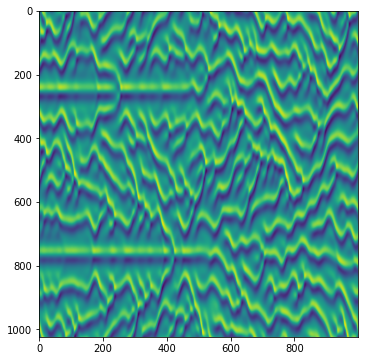

In [14]:
import scipy.io
import matplotlib.pyplot as plt
mat = scipy.io.loadmat('KSres2.mat')
u = mat['uu']
dt = mat['dt'][0][0]
dx = mat['dx'][0][0]

fig, ax= plt.subplots(figsize=(6,6))
ax.imshow(u[:, :])

u = u[..., np.newaxis]

In [15]:
uobs = Observable('u', 1)
print("u shape:", u.shape)

### define all parameters and "make library"
terms = generate_terms_to(5, observables=[uobs], max_observables=3)
terms0 = []
terms1 = []
for term in terms:
    if term.rank==0:
        terms0.append(term)
    else:
        terms1.append(term)

world_size = np.array(u.shape)
m = 6
qmax = 1
nweights = qmax**2
ndomains = 200
dom_width = 128
dom_time = 20
pad = 0

# fix random seed
np.random.seed(1)

data_dict = {'u': u}

dxs = [dx, dt]

scale_dict = find_scales(data_dict)

char_sizes0 = [get_char_size(term, scale_dict, dx, dt) for term in terms0]
char_sizes1 = [get_char_size(term, scale_dict, dx, dt) for term in terms1]

weights = []
dxs_weight = [(dom_width-1)/2*dx, (dom_time-1)/2*dt] # grid spacing used by weight function

#for domain in domains:
for q1 in range(qmax):
    for q2 in range(qmax):
        weights.append(Weight([m]*2, [q1, q2], [0, 0], dxs=dxs_weight))
#domains = domains*nweights

# make domains and "count" density
domains = make_domains([dom_width, dom_time], world_size, ndomains, pad)

Q0 = make_library(terms0, data_dict, weights, domains, 0, dxs)#, by_parts=False)
Q1 = make_library(terms1, data_dict, weights, domains, 1, dxs)#, by_parts=False)

u shape: (1024, 1000, 1)


In [16]:
ks_terms = ['dt u_i', 'dj^2 u_i', 'dj^2 dk^2 u_i', 'dj u_j * u_i']
col_numbers = [find_term(terms1, name) for name in ks_terms]
Xi, lambd = regress(Q1, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}. (Char. size: {char_sizes0[i]})")
print("Model residual:", lambd)

[Term 2] 0.9999962803889791 * dj^2 dk u_k. (Char. size: 0.0010122065567734603)
[Term 4] 0.9999965848582302 * dt dj^2 dk u_k. (Char. size: 0.0005061032783867302)
[Term 5] 1.0 * dt^2 dj u_j. (Char. size: 0.02625483940424248)
[Term 15] 0.9999961858125029 * dt u_j * dk^2 u_j. (Char. size: 0.005514532737140508)
Model residual: 1.2736170234125315e-08
